# 預測caries

模型完整樣子

In [2]:
from ultralytics import YOLO
import os
import cv2

# 設定模型的權重檔路徑
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'

# 設定推理圖像的資料夾路徑
image_folder = 'data/pic/origin'

# 載入 YOLO 模型
model = YOLO(model_path)

# 執行推理，並指定推理的影像資料夾
# 調整 imgsz 為 1280 以適應你的圖片尺寸，並將 conf 門檻設為 0.15 以保留更多預測結果
results = model.predict(source=image_folder, save=True, imgsz=1280, conf=0.15)

# 設定結果保存的目錄
output_dir = 'results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存結果（預測框、標籤等）
for result in results:
    result.save(output_dir)

# 如果您想要提取並保存預測的框和分類結果
for result in results:
    boxes = result.boxes.xyxy  # 獲取預測框的座標 (xyxy)
    scores = result.boxes.conf  # 信心值
    classes = result.boxes.cls  # 分類結果
    print(f"Boxes: {boxes}, Scores: {scores}, Classes: {classes}")

# 檢查輸入圖片與結果的數量
input_images = os.listdir(image_folder)
print(f"輸入影像數量: {len(input_images)}")
print(f"產生的結果數: {len(results)}")

# 檢查是否有未產生結果的圖片
detected_images = [os.path.basename(result.path) for result in results]
undetected_images = [img for img in input_images if img not in detected_images]
print(f"未偵測到的影像: {undetected_images}")



image 1/100 d:\MCUT\SSTek\task\v4.42\data\pic\origin\caries-0.6741573-260-760_1_2022052768.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Root_canal_filling, 4 Backgrounds, 1688.9ms
image 2/100 d:\MCUT\SSTek\task\v4.42\data\pic\origin\caries-0.8304498-273-734_1_2022041847.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 3 Backgrounds, 1585.7ms
image 3/100 d:\MCUT\SSTek\task\v4.42\data\pic\origin\caries-0.8355091-269-741_1_2022060118.png: 960x1280 1 Alveolar_bone, 2 Crowns, 1 Dentin, 8 Post_and_cores, 1 Restoration, 5 Root_canal_fillings, 4 Backgrounds, 1590.5ms
image 4/100 d:\MCUT\SSTek\task\v4.42\data\pic\origin\caries-0.8421053-22-1236_0_2022052776.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 3 Pulps, 1 Restoration, 3 Backgrounds, 1625.9ms
image 5/100 d:\MCUT\SSTek\task\v4.42\data\pic\origin\caries-0.845815-33-1214_1_2022041830.png: 960x1280 1 Alveolar_bone, 1 Caries, 1 Crown, 1 Dentin, 1 Ename

In [ ]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # 載入 matplotlib

# 設定模型的權重檔路徑
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'

# 設定推理圖像的資料夾路徑
image_folder = 'data/pic/origin'

# 載入 YOLO 模型
model = YOLO(model_path)

# 執行推理，並指定推理的影像資料夾
results = model.predict(source=image_folder, save=False, imgsz=1280, conf=0.15)

# 設定結果保存的目錄
output_dir = 'results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 提取並保存預測的分割遮罩
for result in results:
    original_image = cv2.imread(result.path)

    # 創建一個與原圖同尺寸的黑色填充圖像
    mask_image = np.zeros_like(original_image)

    # 遍歷每個物件的預測結果
    for box, score, cls, mask in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls, result.masks.data):
        if cls == 1:  # 假設 'Caries' 的類別 ID 是 1
            # 將分割遮罩轉換為 NumPy 陣列
            mask_np = mask.cpu().numpy()

            # 將遮罩 resize 成與原始影像相同大小
            mask_resized = cv2.resize(mask_np, (original_image.shape[1], original_image.shape[0]))

            # 將遮罩填充到 mask_image 中
            mask_image[mask_resized > 0.5] = [0, 255, 0]  # 用綠色填充

    # 將處理後的遮罩影像與原圖合併
    combined_image = cv2.addWeighted(original_image, 0.5, mask_image, 0.5, 0)

    # 使用 matplotlib 顯示結果
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))  # 將 BGR 轉換為 RGB
    plt.axis('off')  # 不顯示坐標軸
    plt.show()  # 顯示圖像

    # 保存處理後的影像
    cv2.imwrite(os.path.join(output_dir, os.path.basename(result.path)), combined_image)

# 檢查輸入圖片與結果的數量
input_images = os.listdir(image_folder)
print(f"輸入影像數量: {len(input_images)}")
print(f"產生的結果數: {len(results)}")

# 檢查是否有未產生結果的圖片
detected_images = [os.path.basename(result.path) for result in results]
undetected_images = [img for img in input_images if img not in detected_images]
print(f"未偵測到的影像: {undetected_images}")


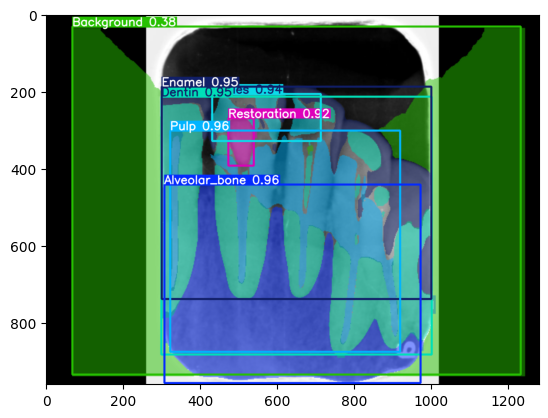

In [6]:
import matplotlib.pyplot as plt
def show_img_by_path(img_path):
    test_img=cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
    plt.imshow(test_img)
    plt.show()
show_img_by_path('data/pic/runs/segment/predict2/caries-0.6741573-260-760_1_2022052768.png')

In [ ]:
# 查看模型標籤
from ultralytics import YOLO

# 載入 YOLOv8 模型
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'
model = YOLO(model_path)

# 查看模型的標籤
labels = model.names
print("Model Labels:\n", labels)


標記蛀牙位置

In [ ]:
from ultralytics import YOLO
import os
import cv2  # 載入 OpenCV 用於圖像處理
import numpy as np  # 載入 NumPy 用於數據處理

# 設定模型的權重檔路徑
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'

# 設定推理圖像的資料夾路徑
image_folder = 'data/pic/origin'
# 載入 YOLO 模型
model = YOLO(model_path)

# 執行推理，並指定推理的影像資料夾
results = model.predict(source=image_folder, save=False, imgsz=640, conf=0.25)

# 設定結果保存的目錄
output_dir = 'result'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 遍歷結果
for result in results:
    # 讀取原始影像
    original_image = cv2.imread(result.path)

    # 遍歷每個物件的預測結果
    for box, score, cls, mask in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls, result.masks.data):
        if cls == 1:  # 'Caries' 的類別 ID 是 1
            # 提取邊界框的座標
            x1, y1, x2, y2 = map(int, box)

            # 將分割遮罩轉換為 NumPy 陣列
            mask_np = mask.cpu().numpy()  # 將 tensor 轉換為 NumPy 陣列

            # 將遮罩 resize 成與原始影像相同大小
            mask_resized = cv2.resize(mask_np, (original_image.shape[1], original_image.shape[0]))

            # 創建一個與原圖同尺寸的紅色填充圖像（用於上色）
            color_mask = np.zeros_like(original_image)
            color_mask[mask_resized > 0.5] = [0, 255, 0]  # 填充綠色

            # 使用 cv2.addWeighted 來混合原始圖像和紅色遮罩，實現半透明效果
            alpha = 0.5  # 設定透明度 (0.5 代表半透明)
            colored_image = cv2.addWeighted(original_image, 1 - alpha, color_mask, alpha, 0)

            # 儲存處理後的影像
            cv2.imwrite(os.path.join(output_dir, os.path.basename(result.path)), colored_image)
            
            # 檢查輸入圖片與結果的數量
            input_images = os.listdir(image_folder)
            print(f"輸入影像數量: {len(input_images)}")
            print(f"產生的結果數: {len(results)}")

            # 檢查是否有未產生結果的圖片
            detected_images = [os.path.basename(result.path) for result in results]
            undetected_images = [img for img in input_images if img not in detected_images]
            print(f"未偵測到的影像: {undetected_images}")


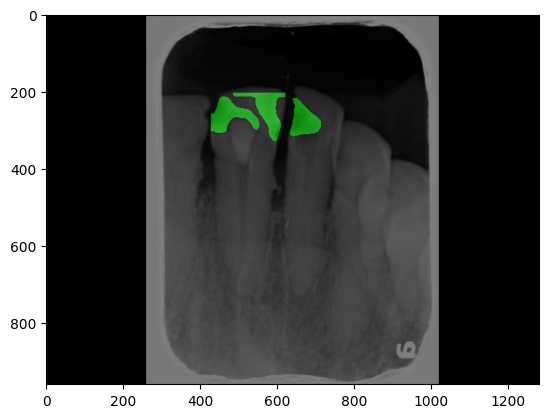

In [7]:
show_img_by_path('data/pic/result\caries-0.6741573-260-760_1_2022052768.png')

In [ ]:
from ultralytics import YOLO
import os
import cv2
import numpy as np

# 設定模型的權重檔路徑
model_path = 'dentistry_yolov9e-seg_all_20240815_4.34.pt'

# 設定推理圖像的資料夾路徑
image_folder = 'data/pic/origin'
model = YOLO(model_path)

# 執行推理
results = model.predict(source=image_folder, save=False, imgsz=640, conf=0.25)

# 設定結果保存的目錄
output_dir = 'data/pic/result'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 遍歷結果
for result in results:
    original_image = cv2.imread(result.path)

    found_caries = False
    for box, score, cls, mask in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls, result.masks.data):
        if cls == 1:  # 'Caries'
            found_caries = True
            x1, y1, x2, y2 = map(int, box)
            mask_np = mask.cpu().numpy()
            mask_resized = cv2.resize(mask_np, (original_image.shape[1], original_image.shape[0]))
            color_mask = np.zeros_like(original_image)
            color_mask[mask_resized > 0.5] = [0, 255, 0]
            alpha = 0.5
            colored_image = cv2.addWeighted(original_image, 1 - alpha, color_mask, alpha, 0)
            cv2.imwrite(os.path.join(output_dir, os.path.basename(result.path)), colored_image)

    if not found_caries:
        cv2.imwrite(os.path.join(output_dir, os.path.basename(result.path)), original_image)

print("所有影像處理完成。")



In [3]:
import os
import cv2

# 定義資料夾路徑
folder1 = 'data/pic/origin'  
folder2 = 'data/pic/result'  
folder3 = 'data\pic\color\Caries_color'  
output_folder = 'data/pic/output2'  

# 檢查並創建輸出資料夾
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 獲取資料夾中的圖片名稱列表
image_filenames = os.listdir(folder1)

for filename in image_filenames:
    # img_path1 = os.path.join(folder1, filename)  # 原圖
    img_path2 = os.path.join(folder2, filename)  # 結果檔案
    img_path3 = os.path.join(folder3, filename)  # 其他檔案

    # 印出檔案路徑以進行調試
    print(f"正在讀取檔案: {img_path2}, {img_path3}")

    # img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2) if os.path.exists(img_path2) else None
    img3 = cv2.imread(img_path3) if os.path.exists(img_path3) else None

    if img2 is None or img3 is None:
        print(f"無法讀取檔案: {filename}. 跳過此檔案。")
        continue

    # height, width = img1.shape[:2]
    height, width = img2.shape[:2] if img2 is not None else img3.shape[:2]
    img2 = cv2.resize(img2, (width, height)) if img2 is not None else img2
    img3 = cv2.resize(img3, (width, height)) if img3 is not None else img3

    # 將兩張圖片水平拼接
    combined_img = cv2.hconcat([img for img in [img2, img3] if img is not None])

    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, combined_img)

print("圖片拼接完成，已保存到:", output_folder)


<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
C:\Users\SSTek\AppData\Local\Temp\ipykernel_408\324384674.py:7: SyntaxWarning: invalid escape sequence '\p'
  folder3 = 'data\pic\color\Caries_color'


正在讀取檔案: data/pic/result\caries-0.6741573-260-760_1_2022052768.png, data\pic\color\Caries_color\caries-0.6741573-260-760_1_2022052768.png
正在讀取檔案: data/pic/result\caries-0.8304498-273-734_1_2022041847.png, data\pic\color\Caries_color\caries-0.8304498-273-734_1_2022041847.png
正在讀取檔案: data/pic/result\caries-0.8355091-269-741_1_2022060118.png, data\pic\color\Caries_color\caries-0.8355091-269-741_1_2022060118.png
正在讀取檔案: data/pic/result\caries-0.8421053-22-1236_0_2022052776.png, data\pic\color\Caries_color\caries-0.8421053-22-1236_0_2022052776.png
正在讀取檔案: data/pic/result\caries-0.845815-33-1214_1_2022041830.png, data\pic\color\Caries_color\caries-0.845815-33-1214_1_2022041830.png
正在讀取檔案: data/pic/result\caries-0.8480566-272-736_1_2022030481.png, data\pic\color\Caries_color\caries-0.8480566-272-736_1_2022030481.png
正在讀取檔案: data/pic/result\caries-0.8480566-33-1214_0_2022042506.png, data\pic\color\Caries_color\caries-0.8480566-33-1214_0_2022042506.png
正在讀取檔案: data/pic/result\caries-0.8510638-26

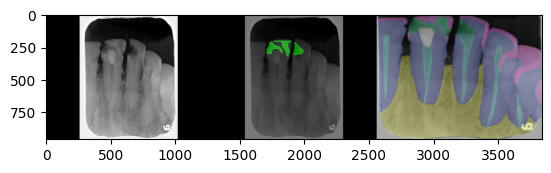

In [8]:
show_img_by_path('data/pic/output1/caries-0.6741573-260-760_1_2022052768.png')

# 統計
使用自適應門檻  
查看正確率  
利用 混淆矩陣來表示

混淆矩陣:
[[ 2468596 16171209]
 [ 9351374 94888821]]
準確率 (Accuracy): 79.23%
精確率 (Precision): 85.44%
召回率 (Recall): 91.03%
F1 分數 (F1 Score): 88.15%


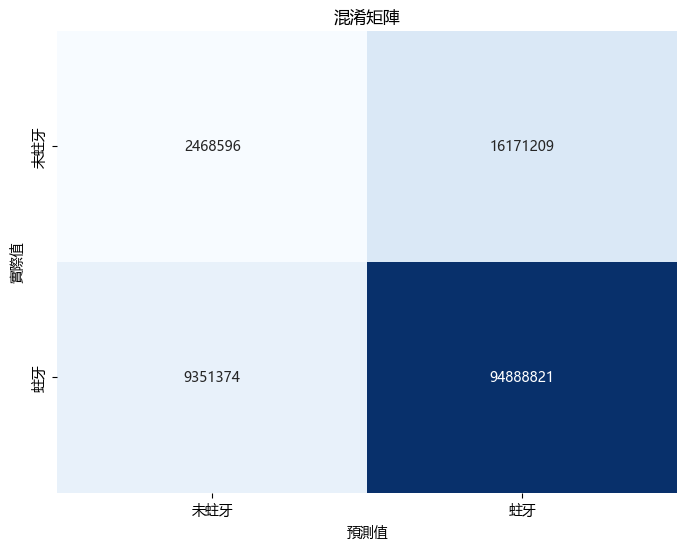

In [7]:
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import glob
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor

# 圖片所在的資料夾路徑
images_path = "data/pic/output1/*.png"  # 根據實際資料夾位置和檔案格式修改

# 初始化結果列表
all_ground_truth = []
all_predictions = []
cavity_positions = []  # 用於儲存蛀牙位置

# 每張圖片的寬度分佈比，例如圖片分為三個區域 (1/3 左邊，1/3 中間，1/3 右邊)
split_ratio = [1/3, 1/3, 1/3]

def process_image(image_file):
    try:
        # 確保檔案是否可讀取
        if not os.access(image_file, os.R_OK):
            print(f"無法存取圖片：{image_file}")
            return None, None
        
        # 讀取圖片
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"無法讀取圖片：{image_file}")
            return None, None
        
        # 計算每個區域的寬度
        h, w = image.shape
        width_raw = int(w * split_ratio[0])
        width_predict = int(w * split_ratio[1])
        
        # 分割圖片
        predicted_image = image[:, width_raw:width_raw + width_predict]
        ground_truth_image = image[:, width_raw + width_predict:]
        
        # 使用自適應門檻進行二值化處理
        pred_binary = cv2.adaptiveThreshold(predicted_image, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
        gt_binary = cv2.adaptiveThreshold(ground_truth_image, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)

        # 展開成一維數組
        pred_flat = pred_binary.flatten()
        gt_flat = gt_binary.flatten()
        
        # 找到蛀牙的位置 (標記為 1 的區域)
        contours, _ = cv2.findContours(pred_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        positions = []  # 儲存每個蛀牙的位置
        for contour in contours:
            if cv2.contourArea(contour) > 10:  # 可以根據實際情況調整最小面積
                x, y, w, h = cv2.boundingRect(contour)
                positions.append((x, y, w, h))  # 儲存蛀牙的位置 (x, y, 寬度, 高度)

        cavity_positions.extend(positions)  # 將當前圖片的蛀牙位置添加到總列表中

        return gt_flat, pred_flat
        
    except Exception as e:
        print(f"處理圖片 {image_file} 時發生錯誤：{e}")
        return None, None

# 使用 ThreadPoolExecutor 進行並行處理
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, image_file) for image_file in glob.glob(images_path)]
    
    for future in futures:
        gt, pred = future.result()
        if gt is not None and pred is not None:
            all_ground_truth.extend(gt)
            all_predictions.extend(pred)

# 計算混淆矩陣和其他統計數據
cm = confusion_matrix(all_ground_truth, all_predictions)
accuracy = accuracy_score(all_ground_truth, all_predictions)
precision = precision_score(all_ground_truth, all_predictions)
recall = recall_score(all_ground_truth, all_predictions)
f1 = f1_score(all_ground_truth, all_predictions)

# 顯示結果
print("混淆矩陣:")
print(cm)
print(f"準確率 (Accuracy): {accuracy * 100:.2f}%")
print(f"精確率 (Precision): {precision * 100:.2f}%")
print(f"召回率 (Recall): {recall * 100:.2f}%")
print(f"F1 分數 (F1 Score): {f1 * 100:.2f}%")


# # 顯示蛀牙位置
# print("蛀牙位置 (x, y, 寬度, 高度):")
# for pos in cavity_positions:
#     print(pos)

# 設定支持中文的字型
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 正常顯示負號

# 畫出混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['未蛀牙', '蛀牙'], yticklabels=['未蛀牙', '蛀牙'])
plt.ylabel('實際值')
plt.xlabel('預測值')
plt.title('混淆矩陣')
plt.show()


承上  
加入optuna去優化自適應門檻

[I 2024-10-29 17:39:16,147] A new study created in memory with name: no-name-7478ce83-187f-4a26-9128-0a308d9a5bbf
[I 2024-10-29 17:40:29,282] Trial 0 finished with value: 4.6266080739543245 and parameters: {'block_size': 15, 'C': -8}. Best is trial 0 with value: 4.6266080739543245.
[I 2024-10-29 17:41:10,522] Trial 1 finished with value: 95.81335538220696 and parameters: {'block_size': 7, 'C': 3}. Best is trial 1 with value: 95.81335538220696.
[I 2024-10-29 17:41:47,035] Trial 2 finished with value: 95.66696077136793 and parameters: {'block_size': 11, 'C': 4}. Best is trial 1 with value: 95.81335538220696.
[I 2024-10-29 17:42:22,893] Trial 3 finished with value: 98.72103783095076 and parameters: {'block_size': 9, 'C': 7}. Best is trial 3 with value: 98.72103783095076.
[I 2024-10-29 17:42:57,448] Trial 4 finished with value: 98.68084003864026 and parameters: {'block_size': 11, 'C': 8}. Best is trial 3 with value: 98.72103783095076.
[I 2024-10-29 17:43:32,292] Trial 5 finished with value

最佳參數的混淆矩陣 (每張圖片為單位):
[[    45574   1770702]
 [  1331632 119732092]]
準確率 (Accuracy): 97.48%
精確率 (Precision): 98.54%
召回率 (Recall): 98.90%
F1 分數 (F1 Score): 98.72%


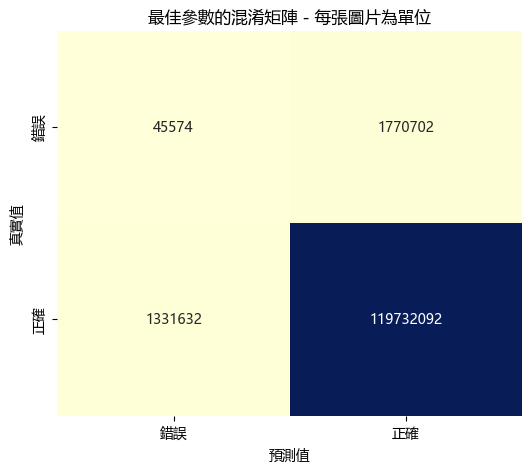

In [4]:
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import glob
import optuna
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 圖片所在的資料夾路徑
images_path = "data/pic/output1/*.png"  # 根據實際資料夾位置和檔案格式修改
split_ratio = [1/3, 1/3, 1/3]

# 定義處理影像的函數
def process_image(image_file, block_size, C):
    try:
        # 讀取圖片
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"無法讀取圖片：{image_file}")
            return None, None

        # 計算每個區域的寬度
        h, w = image.shape
        width_raw = int(w * split_ratio[0])
        width_predict = int(w * split_ratio[1])

        # 分割圖片
        predicted_image = image[:, width_raw:width_raw + width_predict]
        ground_truth_image = image[:, width_raw + width_predict:]

        # 使用自適應門檻進行二值化處理
        pred_binary = cv2.adaptiveThreshold(predicted_image, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, block_size, C)
        gt_binary = cv2.adaptiveThreshold(ground_truth_image, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, block_size, C)

        # 展開成一維數組
        pred_flat = pred_binary.flatten()
        gt_flat = gt_binary.flatten()

        return gt_flat, pred_flat
    except Exception as e:
        print(f"處理圖片 {image_file} 時發生錯誤：{e}")
        return None, None

# 定義 Optuna 的目標函數
def objective(trial):
    # 隨機選擇 block size 和 C 的值
    block_size = trial.suggest_int("block_size", 3, 21, step=2)  # 必須為奇數
    C = trial.suggest_int("C", -10, 10)

    all_ground_truth = []
    all_predictions = []

    # 使用並行處理來加速圖片處理
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, image_file, block_size, C) for image_file in glob.glob(images_path)]
        
        for future in futures:
            gt, pred = future.result()
            if gt is not None and pred is not None:
                all_ground_truth.append(gt)  # 添加真實標籤
                all_predictions.append(pred)  # 添加預測結果

    # 將所有的 ground truth 和預測扁平化
    all_ground_truth_flat = np.concatenate(all_ground_truth)
    all_predictions_flat = np.concatenate(all_predictions)

    # 計算每張圖片為單位的 F1 分數
    f1 = f1_score(all_ground_truth_flat, all_predictions_flat) * 100
    return f1  # Optuna 將嘗試最大化這個分數

# 使用 Optuna 進行超參數搜尋
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # 設定嘗試 10 次，根據需求調整

# 最佳參數
best_block_size = study.best_params['block_size']
best_C = study.best_params['C']

# 使用最佳參數重新計算混淆矩陣和指標
all_ground_truth = []
all_predictions = []

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, image_file, best_block_size, best_C) for image_file in glob.glob(images_path)]
    
    for future in futures:
        gt, pred = future.result()
        if gt is not None and pred is not None:
            all_ground_truth.append(gt)
            all_predictions.append(pred)

# 將所有的 ground truth 和預測扁平化
all_ground_truth_flat = np.concatenate(all_ground_truth)
all_predictions_flat = np.concatenate(all_predictions)

# 計算並顯示最佳參數的混淆矩陣和指標
cm = confusion_matrix(all_ground_truth_flat, all_predictions_flat)
accuracy = accuracy_score(all_ground_truth_flat, all_predictions_flat) * 100
precision = precision_score(all_ground_truth_flat, all_predictions_flat) * 100
recall = recall_score(all_ground_truth_flat, all_predictions_flat) * 100
f1 = f1_score(all_ground_truth_flat, all_predictions_flat) * 100

print("最佳參數的混淆矩陣 (每張圖片為單位):")
print(cm)
print(f"準確率 (Accuracy): {accuracy:.2f}%")
print(f"精確率 (Precision): {precision:.2f}%")
print(f"召回率 (Recall): {recall:.2f}%")
print(f"F1 分數 (F1 Score): {f1:.2f}%")

# 繪製最佳參數的混淆矩陣
# 設定支持中文的字型
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 正常顯示負號
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False, xticklabels=["錯誤", "正確"], yticklabels=["錯誤", "正確"])
plt.xlabel("預測值")
plt.ylabel("真實值")
plt.title("最佳參數的混淆矩陣 - 每張圖片為單位")
plt.show()


# 10/30
分辨正確與錯誤再將錯誤分成偽陽性與偽陰性

In [5]:
import cv2
import numpy as np
import shutil
import os
import csv

# 參數設定
image_folder = 'data/pic/output2'  # 原始圖片資料夾
correct_folder = 'data/FP_FN/correct'  # 正確分類圖片儲存資料夾
fp_folder = 'data/FP_FN/FP'  # False Positive 圖片儲存資料夾
fn_folder = 'data/FP_FN/FN'  # False Negative 圖片儲存資料夾
threshold = 0.98  # 相似度的閾值

# 清空資料夾中的舊圖片
for folder in [correct_folder, fp_folder, fn_folder]:
    if os.path.exists(folder):
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
    else:
        os.makedirs(folder, exist_ok=True)

# 計數與記錄
correct_count = 0
false_positive_count = 0
false_negative_count = 0
false_positive_images = []
false_negative_images = []

# 讀取每張圖片進行處理
for filename in os.listdir(image_folder):
    if filename.endswith(".png"):
        image_path = os.path.join(image_folder, filename)
        combined_image = cv2.imread(image_path)

        # 確保圖片為有效大小以進行分割 (假設圖片寬度為偶數)
        height, width, _ = combined_image.shape
        mid_width = width // 2
        
        # 分割圖片為左邊（預測）和右邊（正確）
        predict_image = combined_image[:, :mid_width]
        groundtruth_image = combined_image[:, mid_width:]

        # 將圖片從 BGR 轉換為 HSV
        hsv_predict = cv2.cvtColor(predict_image, cv2.COLOR_BGR2HSV)
        hsv_groundtruth = cv2.cvtColor(groundtruth_image, cv2.COLOR_BGR2HSV)

        # 定義亮綠色和暗綠色的 HSV 範圍
        bright_green_lower = np.array([30, 100, 100])
        bright_green_upper = np.array([70, 255, 255])
        dark_green_lower = np.array([20, 50, 50])
        dark_green_upper = np.array([70, 150, 150])

        # 過濾亮綠色和暗綠色區域
        mask_predict = cv2.inRange(hsv_predict, bright_green_lower, bright_green_upper)
        mask_groundtruth = cv2.inRange(hsv_groundtruth, dark_green_lower, dark_green_upper)

        # 將遮罩展平，方便相似度計算
        predict_flat = mask_predict.flatten()
        groundtruth_flat = mask_groundtruth.flatten()

        # 計算相似度
        similarity = np.sum(predict_flat == groundtruth_flat) / len(predict_flat)

        # 根據相似度分類
        if similarity >= threshold:
            correct_count += 1
            # 複製圖片到 correct 資料夾
            shutil.copy(image_path, os.path.join(correct_folder, filename))
        else:
            # 計算 false positive 與 false negative
            false_positives = np.sum((predict_flat == 255) & (groundtruth_flat == 0))
            false_negatives = np.sum((predict_flat == 0) & (groundtruth_flat == 255))

            if false_positives > false_negatives:
                false_positive_count += 1
                false_positive_images.append(filename)
                # 複製圖片到 FP 資料夾
                shutil.copy(image_path, os.path.join(fp_folder, filename))
            else:
                false_negative_count += 1
                false_negative_images.append(filename)
                # 複製圖片到 FN 資料夾
                shutil.copy(image_path, os.path.join(fn_folder, filename))

# 顯示結果
print("正確的張數:", correct_count)
print("False Positive 的張數:", false_positive_count)
print("False Negative 的張數:", false_negative_count)

# 顯示錯誤分類的圖片名稱
print("\nFalse Positive 圖片名稱:")
for img in false_positive_images:
    print(img)

print("\nFalse Negative 圖片名稱:")
for img in false_negative_images:
    print(img)

# 將結果寫入 CSV 檔案
with open('classification_results.csv', 'w', newline='') as csvfile:
    fieldnames = ['Result', 'Count', 'Image Names']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerow({'Result': 'Correct', 'Count': correct_count, 'Image Names': ', '.join([])})
    writer.writerow({'Result': 'False Positive', 'Count': false_positive_count, 'Image Names': ', '.join(false_positive_images)})
    writer.writerow({'Result': 'False Negative', 'Count': false_negative_count, 'Image Names': ', '.join(false_negative_images)})

print("結果已寫入 classification_results.csv")


正確的張數: 91
False Positive 的張數: 9
False Negative 的張數: 0

False Positive 圖片名稱:
caries-0.8540925-268-744_0_2022060601144.png
caries-0.8864266-2-1276_0_2022060190.png
caries-1.5-34-1212_0_2022052732.png
caries-1.5-37-1206_0_2022041837.png
caries-1.5-37-1206_0_2022052742.png
caries-1.5-37-1206_0_2022060109.png
caries-1.5-37-1206_0_2022061444.png
caries-1.5-37-1206_1_2022060609.png
caries-1.5-40-1200_0_2022052740.png

False Negative 圖片名稱:
結果已寫入 classification_results.csv


分析FP、FN

In [14]:
import os
import cv2
import numpy as np

# 設定資料夾路徑
fp_folder = "data/FP_FN/FP"
fn_folder = "data/FP_FN/FN"

# 定義綠色範圍
lower_green = np.array([35, 100, 100])
upper_green = np.array([85, 255, 255])

def analyze_image(image_path):
    # 讀取圖片
    image = cv2.imread(image_path)
    
    # 將圖片轉為HSV色彩空間
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # 建立綠色遮罩
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    
    # 計算綠色區域比例
    green_area = np.sum(green_mask == 255)
    total_area = green_mask.size
    green_ratio = green_area / total_area
    
    # 根據綠色區域比例進行分析
    if green_ratio > 0.5:
        return "圖片中有大量的綠色區域，可能預測錯誤為陽性。"
    elif green_ratio < 0.05:
        return "圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。"
    else:
        return "圖片中綠色區域比例中等，可能由於其他原因導致分類錯誤。"

def analyze_folder(folder_path, label):
    print(f"\n分析 {label} 資料夾中的圖片問題：")
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(folder_path, filename)
            result = analyze_image(image_path)
            print(f"{filename}: {result}")

# 分析 FP 資料夾中的圖片
analyze_folder(fp_folder, "False Positive")

# 分析 FN 資料夾中的圖片
analyze_folder(fn_folder, "False Negative")



分析 False Positive 資料夾中的圖片問題：
caries-0.8540925-268-744_0_2022060601144.png: 圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。
caries-0.8864266-2-1276_0_2022060190.png: 圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。
caries-1.5-34-1212_0_2022052732.png: 圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。
caries-1.5-37-1206_0_2022041837.png: 圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。
caries-1.5-37-1206_0_2022052742.png: 圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。
caries-1.5-37-1206_0_2022060109.png: 圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。
caries-1.5-37-1206_0_2022061444.png: 圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。
caries-1.5-37-1206_1_2022060609.png: 圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。
caries-1.5-40-1200_0_2022052740.png: 圖片中幾乎沒有綠色區域，可能預測錯誤為陰性。

分析 False Negative 資料夾中的圖片問題：
